In [6]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import rdMolDescriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv

In [2]:
mtor = []
activity = []

with open('data/chembl_mtor_ic50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for m in reader:
        mtor.append(Chem.MolFromSmiles(m['Smiles']))
        activity.append(float(m['pChEMBL Value']) if m['pChEMBL Value'] else 0)

In [3]:
suppl = Chem.SDMolSupplier('data/drugbank.sdf')
drugbank = [m for m in suppl if m]

[10:30:04] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 28 ignored.
[10:30:04] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 28 ignored.
[10:30:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[10:30:04] ERROR: Could not sanitize molecule ending on line 250947
[10:30:04] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[10:30:04] Explicit valence for atom # 17 O, 3, is greater than permitted
[10:30:04] ERROR: Could not sanitize molecule ending on line 258130
[10:30:04] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[10:30:05] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[10:30:05] ERROR: Could not sanitize molecule ending on line 261581
[10:30:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[10:30:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 7 8 9 10 11 12 13 14 15 16 17
[10:30:05] ERROR: Could not 

In [7]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [8]:
# standardization
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [9]:
mtor_df = pd.DataFrame([{'mol': m, 'smiles': Chem.MolToSmiles(m), 'source': 'mtor'}for m in mtor if standardize(m)], columns=['mol', 'smiles', 'source'])
drugbank_df = pd.DataFrame([{'mol': m, 'smiles': Chem.MolToSmiles(m), 'source': 'drugbank'}for m in drugbank if standardize(m)], columns=['mol', 'smiles', 'source'])

In [10]:
df = pd.concat([mtor_df, drugbank_df], ignore_index=True)

In [11]:
df

,mol,smiles,source
0,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccccc4F)n3...,mtor
1,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(OCc4cccc(C)c4)n3)cc2s1,mtor
2,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,COc1cccc(COc2nccc(-c3ccc4nc(NC(C)=O)sc4c3)n2)c1,mtor
3,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccc(F)cc4)...,mtor
4,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(N(C)S(=O)(=O)c4ccccc4F...,mtor
...,...,...,...
10733,<rdkit.Chem.rdchem.Mol object at 0x0000029151D...,Oc1ccc(Cl)cc1,drugbank
10734,<rdkit.Chem.rdchem.Mol object at 0x0000029151D...,O=c1ccc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)...,drugbank
10735,<rdkit.Chem.rdchem.Mol object at 0x0000029151D...,CC(=O)Nc1ccc(C(=O)O)cc1.CC(=O)Nc1ccc(C(=O)O)cc...,drugbank
10736,<rdkit.Chem.rdchem.Mol object at 0x0000029151D...,CCCCCCCCCCCCOC(=O)CS(=O)(=O)[O-].[Na+],drugbank


In [12]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df['mol']), columns=[*(f"MQN_{x}" for x in range(1,43))]))

In [13]:
df

,mol,smiles,source,MQN_1,MQN_2,MQN_3,MQN_4,MQN_5,MQN_6,MQN_7,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccccc4F)n3...,mtor,19,1,0,0,0,2,0,...,0,0,1,3,0,0,0,0,2,1
1,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(OCc4cccc(C)c4)n3)cc2s1,mtor,21,0,0,0,0,1,0,...,0,0,1,3,0,0,0,0,2,1
2,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,COc1cccc(COc2nccc(-c3ccc4nc(NC(C)=O)sc4c3)n2)c1,mtor,21,0,0,0,0,1,0,...,0,0,1,3,0,0,0,0,2,1
3,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccc(F)cc4)...,mtor,19,1,0,0,0,2,0,...,0,0,1,3,0,0,0,0,2,1
4,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(N(C)S(=O)(=O)c4ccccc4F...,mtor,20,1,0,0,0,2,0,...,0,0,1,3,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10733,<rdkit.Chem.rdchem.Mol object at 0x0000029151D...,Oc1ccc(Cl)cc1,drugbank,6,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10734,<rdkit.Chem.rdchem.Mol object at 0x0000029151D...,O=c1ccc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)...,drugbank,15,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,2,1
10735,<rdkit.Chem.rdchem.Mol object at 0x0000029151D...,CC(=O)Nc1ccc(C(=O)O)cc1.CC(=O)Nc1ccc(C(=O)O)cc...,drugbank,52,0,0,0,0,0,0,...,0,0,2,4,0,0,0,0,2,1
10736,<rdkit.Chem.rdchem.Mol object at 0x0000029151D...,CCCCCCCCCCCCOC(=O)CS(=O)(=O)[O-].[Na+],drugbank,14,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# add fingerprint bit vectors to df
df['fps'] = df.apply(lambda row: Chem.GetMorganFingerprintAsBitVect(row['mol'], 2, nBits=1024), axis=1)

In [15]:
df[:2]

,mol,smiles,source,MQN_1,MQN_2,MQN_3,MQN_4,MQN_5,MQN_6,MQN_7,...,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42,fps
0,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccccc4F)n3...,mtor,19,1,0,0,0,2,0,...,0,1,3,0,0,0,0,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(OCc4cccc(C)c4)n3)cc2s1,mtor,21,0,0,0,0,1,0,...,0,1,3,0,0,0,0,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
# split the data into training and testing
train, test = train_test_split(df)
print(len(train), len(test))

8053 2685


In [19]:
# random forest
rf = ensemble.RandomForestClassifier()
rf.fit(train[(f"MQN_{x}" for x in range(1, 43))], train['source'])

RandomForestClassifier()

In [20]:
pred_test = rf.predict(test[(f"MQN_{x}" for x in range(1, 43))])

In [21]:
pred_test

array(['mtor', 'drugbank', 'drugbank', ..., 'mtor', 'mtor', 'mtor'],
      dtype=object)

In [22]:
acc = accuracy_score(test['source'], pred_test)

In [23]:
mtor_df = pd.DataFrame([{'mol': m, 'smiles': Chem.MolToSmiles(m), 'activity': activity[i]}for i,m in enumerate(mtor) if standardize(m)], columns=['mol', 'smiles', 'activity'])

In [24]:
mtor_df

,mol,smiles,activity
0,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccccc4F)n3...,7.35
1,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(OCc4cccc(C)c4)n3)cc2s1,0.00
2,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,COc1cccc(COc2nccc(-c3ccc4nc(NC(C)=O)sc4c3)n2)c1,0.00
3,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccc(F)cc4)...,6.14
4,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(N(C)S(=O)(=O)c4ccccc4F...,0.00
...,...,...,...
4586,<rdkit.Chem.rdchem.Mol object at 0x0000029149D...,COc1ncc(-c2ccc3nccc(=O)n3c2)cc1NS(=O)(=O)c1ccc...,0.00
4587,<rdkit.Chem.rdchem.Mol object at 0x0000029149D...,O=c1ccnc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccc(F)cc4...,0.00
4588,<rdkit.Chem.rdchem.Mol object at 0x0000029149D...,C=CC(=O)Nc1ccc(-n2c(=O)ccc3oc4ccc(-c5cccnc5)cc...,6.64
4589,<rdkit.Chem.rdchem.Mol object at 0x0000029149D...,COc1ccc(-c2ccc3c(N4CCOCC4)nc(CN)nc3n2)cc1CO,6.84


In [25]:
mtor_data = mtor_df[mtor_df['activity']>0]

In [26]:
mtor_data = mtor_data.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df['mol']), columns=[*(f"MQN_{x}" for x in range(1,43))]))
mtor_data

,mol,smiles,activity,MQN_1,MQN_2,MQN_3,MQN_4,MQN_5,MQN_6,MQN_7,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccccc4F)n3...,7.35,19,1,0,0,0,2,0,...,0,0,1,3,0,0,0,0,2,1
3,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccc(F)cc4)...,6.14,19,1,0,0,0,2,0,...,0,0,1,3,0,0,0,0,2,1
5,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,COc1ccc(S(=O)(=O)Nc2cccc(-c3ccc4nc(NC(C)=O)sc4...,5.82,22,0,0,0,0,2,0,...,0,0,1,3,0,0,0,0,2,1
7,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,O=c1[nH]c2ncc(-c3ccc(O)cc3)nc2n1C1CCOCC1,5.78,16,0,0,0,0,0,0,...,0,0,1,3,0,0,0,0,2,1
8,<rdkit.Chem.rdchem.Mol object at 0x0000029149C...,CC(C)(O)c1ccc(-c2cnc3[nH]c(=O)n(CC4CCCCC4)c3n2...,7.52,21,0,0,0,0,0,0,...,0,0,1,3,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4582,<rdkit.Chem.rdchem.Mol object at 0x0000029149D...,CCNC(=O)Nc1ccc(-c2nc3c(c(N4CCOC[C@@H]4C)n2)CCN...,7.41,24,0,0,0,0,0,0,...,0,1,0,4,0,0,0,0,2,1
4584,<rdkit.Chem.rdchem.Mol object at 0x0000029149D...,COc1ncc(-c2ccc3ncn([C@H]4CCN(C(=O)C5CC5)C4)c(=...,6.68,28,1,0,0,0,1,0,...,1,0,1,4,0,0,0,0,2,1
4585,<rdkit.Chem.rdchem.Mol object at 0x0000029149D...,COc1ncc(-c2ccc3ncc(Cl)c(=O)n3c2)cc1NS(=O)(=O)c...,8.33,20,2,1,0,0,1,0,...,0,0,0,4,0,0,0,0,2,1
4588,<rdkit.Chem.rdchem.Mol object at 0x0000029149D...,C=CC(=O)Nc1ccc(-n2c(=O)ccc3oc4ccc(-c5cccnc5)cc...,6.64,25,0,0,0,0,0,0,...,0,0,1,4,0,0,0,0,4,2


In [27]:
# split the data into training and testing
mtor_train, mtor_test = train_test_split(mtor_data)

In [28]:
# random forest
rf = ensemble.RandomForestRegressor()
rf.fit(mtor_train[(f"MQN_{x}" for x in range(1, 43))], mtor_train['activity'])

RandomForestRegressor()

In [29]:
pred_activity = rf.predict(mtor_test[(f"MQN_{x}" for x in range(1, 43))])

In [30]:
from sklearn.metrics import r2_score

In [31]:
r2_score(mtor_test['activity'], pred_activity)

0.6409295875805305

<Axes: xlabel='activity'>

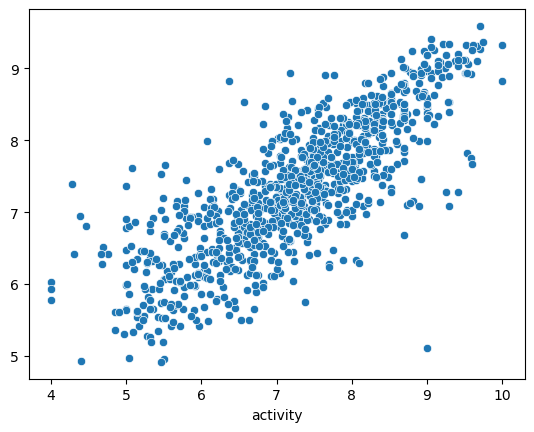

In [32]:
seaborn.scatterplot(x=mtor_test['activity'], y=pred_activity)